# Capstone Project Jupyter Notebook

In [63]:
import folium 
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
%matplotlib inline 

In [13]:
# Load data from the url and only pick the first tabel as a Data Frame
data = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]

In [18]:
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
# All neighbourhood for the same Postal code has been concated into a single row
data = data[data['Borough']!= 'Not assigned']
data.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [19]:
# There is no cell with Not assigned neighborhood 
data[data['Neighbourhood'] == 'Not assigned']

,Postal Code,Borough,Neighbourhood


In [22]:
print(data.shape)

(103, 3)


In [25]:
# Load Geocoder csv
geo_data = pd.read_csv("Data/Geospatial_Coordinates.csv")

In [26]:
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [27]:
# Merge data frame based on Postal Code
result_df = pd.merge(data, geo_data,  how='left', left_on=['Postal Code'], right_on = ['Postal Code'])
result_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [34]:
# Get toronto data
Toronto_df = result_df[result_df['Borough'].str.contains('Toronto')]

In [35]:
Toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [39]:
X = Toronto_df[['Latitude', 'Longitude']]
X.head()

,Latitude,Longitude
2,43.654260,-79.360636
4,43.662301,-79.389494
9,43.657162,-79.378937
15,43.651494,-79.375418
19,43.676357,-79.293031


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f41766ed080>,
                 k=None, metric=None, model=None, timings=True)

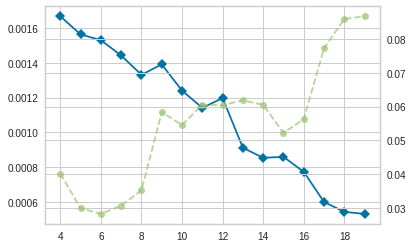

In [44]:
# Using Elbow Method to test different k for k-means

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,20))

visualizer.fit(X)        # Fit the data to the visualizer

In [45]:
# It's hard to tell what's the best K value for this project, so I am picking 8 as k value
kmeans = KMeans(n_clusters=8, random_state=0).fit(X)
labels = kmeans.labels_

In [48]:
Toronto_df['Kmeans_8_labels'] = labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
Toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Kmeans_8_labels
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,7
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,3


In [64]:
# Visualization
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
Toronto_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

# set color scheme for the clusters
x = np.arange(8)
ys = [i + x + (i*x)**2 for i in range(8)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Neighbourhood'], Toronto_df['Kmeans_8_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Toronto_map)
       
Toronto_map

# display(Toronto_map)